In [64]:
import numpy as np,matplotlib.pyplot as plt,mne,os,sys,glob,numpy as np,torch
from mne.datasets import eegbci
from IPython.display import clear_output
from torch import nn
import torch.optim as optim
from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal
import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable
import math
from mne import (io, compute_raw_covariance, read_events, pick_types, Epochs)
from mne.preprocessing import Xdawn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import seaborn as sns
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test

In [65]:
from braindecode.preprocessing import (
    exponential_moving_standardize,
    preprocess,
    Preprocessor)
from numpy import multiply
from braindecode.datasets import MOABBDataset
from braindecode.preprocessing import create_windows_from_events
import torch
from braindecode.util import set_random_seeds

from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from braindecode import EEGClassifier
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
from sklearn.metrics import confusion_matrix
from braindecode.visualization import plot_confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal


import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable
import math
import wandb
import os
import neptune.new.integrations.sklearn as npt_utils
import neptune.new as neptune



os.environ['http_proxy'] = "http://192.41.170.23:3128"
os.environ['https_proxy'] = "http://192.41.170.23:3128"

from braindecode.models import ShallowFBCSPNet, Deep4Net ,HybridNet,EEGInceptionMI,EEGITNet,ATCNet
def create_dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y).long()
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    dl = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)
    return dl

def early_stopping(train_loss, validation_loss, min_delta, tolerance):
    counter = 0
    if (validation_loss - train_loss) > min_delta:
        counter +=1
        if counter >= tolerance:
          return True

def extrack_dataset(dataset):
    for x, y, window_ind in dataset:
        x_shape = x.shape
        y_shape = len(dataset.get_metadata().target)
        break
    X = np.zeros((y_shape,x_shape[0],x_shape[1]))
    y_=[]
    i=0
    for x, y, window_ind in dataset:
        X[i]=x
        y_.append(y)
        i+=1
    #X2 = X[:, 7:8, :]
    #X3= X[:, 11:12, :]
    #(288, 22, 1125)
    #X = np.concatenate((X2,X3), axis=1)
    print(X.shape)

    #X = X.reshape(y_shape,X.shape[2],X.shape[1])
    return X,np.array(y_).T


def extrack_dataset_2class(dataset):
    for x, y, window_ind in dataset:
        x_shape = x.shape
        y_shape = len(dataset.get_metadata().target)
        break
    X = np.zeros((y_shape,x_shape[0],x_shape[1]))
    y_=[]
    i=0
    for x, y, window_ind in dataset:
        X[i]=x
        y_.append(y)
        i+=1
    y = np.array(y_).T
    X_ = np.zeros((int(y_shape/2) ,x_shape[0],x_shape[1])) #for 2 class
    y_for_2class =[]
    j=0
    for i in range(y.shape[0]):
        if y[i] == 0 or y[i] == 1:
            y_for_2class.append(y[i])
            X_[j]=X[i]
            j +=1
    y_for_2class = np.array(y_for_2class).T
    X_ = X_.reshape(y_for_2class.shape[0],X_.shape[2],X_.shape[1])
    return X_,y_for_2class

def extrack_dataset_2class_cut(dataset):
    for x, y, window_ind in dataset:
        x_shape = x.shape
        y_shape = len(dataset.get_metadata().target)
        break
    X = np.zeros((y_shape,x_shape[0],x_shape[1]))
    y_=[]
    i=0
    for x, y, window_ind in dataset:
        X[i]=x
        y_.append(y)
        i+=1
    y = np.array(y_).T
    X_ = np.zeros((int(y_shape/2) ,x_shape[0],x_shape[1])) #for 2 class
    y_for_2class =[]
    j=0
    for i in range(y.shape[0]):
        if y[i] == 0 or y[i] == 1:
            y_for_2class.append(y[i])
            X_[j]=X[i]
            j +=1
    y_for_2class = np.array(y_for_2class).T
    X_ = X_.reshape(y_for_2class.shape[0],X_.shape[2],X_.shape[1])
    #100, 1, 576, 22
    X_ = X_[:,64:320,:]
    print(X_.shape)
    return X_,y_for_2class


def train(model,gpu_num,train_loader,test_loader,
          weights_name=False,
          optimizer = None,
          criterion = None,
          num_epochs=500,
          vail_loader= None,
          save_weights = False,
          neptune = True,
          lr = None
         ):

    # Train the model


    train_loss = []
    valid_loss = [10,11]
    train_accuracy = []
    valid_accuracy = []

    old_loss = 100
    old_acc = 0
    valid_loss_vail = []


    for epoch in range(num_epochs):
        iter_loss = 0.0
        correct = 0
        iterations = 0

        model.train()

        for i, (items, classes) in enumerate(train_loader):
            items = Variable(items)
            classes = classes.type(torch.LongTensor)
            classes = Variable(classes)

            if cuda.is_available():
                items = items.cuda(gpu_num)
                classes = classes.cuda(gpu_num)

            optimizer.zero_grad()
            outputs = model(items)

            #avg_pedic = torch.mean(outputs, 1, True).float()
            #avg_pedic = avg_pedic.reshape(classes.shape[0])
            #print(avg_pedic.shape)
            #print(classes.shape)
            loss = criterion(outputs, classes)

            iter_loss += loss.item()
            loss.backward()
            optimizer.step()

            metrics = {"train/train_loss": loss}

            #print(loss)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == classes.data).sum()
            iterations += 1

        train_loss.append(iter_loss/iterations)


        train_accuracy.append(( correct.float() / len(train_loader.dataset)))
        train_metrics = {"train/train_loss": iter_loss/iterations,
                       "train/train_accuracy": (100 * correct.float() / len(train_loader.dataset))}



        loss = 0.0
        correct = 0
        iterations = 0

        model.eval()

        for i, (items, classes) in enumerate(test_loader):
            classes = classes.type(torch.LongTensor)
            items = Variable(items)
            classes = Variable(classes)

            if cuda.is_available():
                items = items.cuda(gpu_num)
                classes = classes.cuda(gpu_num)


            outputs = model(items)
            #avg_pedic = torch.mean(outputs, 1, True).float()
            #avg_pedic = avg_pedic.reshape(classes.shape[0])

            loss += criterion(outputs, classes).item()

            _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == classes.data).sum()
            #print("correct : {}".format(classes.data))
            #print("predicted : {}".format(predicted))
            iterations += 1

        valid_loss.append(loss/iterations)
        correct_scalar = np.array([correct.clone().cpu()])[0]
        valid_accuracy.append(correct_scalar / len(test_loader.dataset) )

        test_metrics = {"Test/Test_loss": loss/iterations,
                       "Test/Test_accuracy": correct_scalar / len(test_loader.dataset) }

        if save_weights is True:
            if epoch+1 > 2 and valid_loss[-1] < old_loss and old_acc <= valid_accuracy[-1] :
                    newpath = r'./{}'.format(weights_name)
                    if not os.path.exists(newpath):
                        os.makedirs(newpath)
                    torch.save(model.state_dict(),'./{}/{:.4f}_{}_{:.4f}_{:.4f}'.format(weights_name,valid_loss[-1],weights_name,valid_loss[-1],valid_accuracy[-1]))
                    part_weights = './{}/{:.4f}_{}_{:.4f}_{:.4f}'.format(weights_name,valid_loss[-1],weights_name,valid_loss[-1],valid_accuracy[-1])
                    old_loss = valid_loss[-1]
                    old_acc = valid_accuracy[-1]

        print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f , le : %f'
                       %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1],lr))
        if early_stopping(train_loss[-1], valid_loss[-1], min_delta=10, tolerance = 20):
            print("We are at epoch:", epoch+1)
            run[f"epoch/valid_accuracy"].append(valid_accuracy[-1])
            run[f"epoch/train_accuracy"].append(train_accuracy[-1])
            run[f"epoch/train_loss"].append(train_loss[-1])
            run[f"epoch/valid_loss"].append(valid_loss[-1])

            break
        if neptune is True:
            run[f"epoch/valid_accuracy"].append(valid_accuracy[-1])
            run[f"epoch/train_accuracy"].append(train_accuracy[-1])
            run[f"epoch/train_loss"].append(train_loss[-1])
            run[f"epoch/valid_loss"].append(valid_loss[-1])
        if epoch+1 == 1:
            stop_loss = valid_loss[-1]

        if  (epoch+1)//500 == 0 and epoch+1 > 1400 :
            if valid_loss[-1] > valid_loss[-500]:
                print("Stop")
                break

    return train_loss,valid_loss,train_accuracy,valid_accuracy,part_weights
def eval(model,
         gpu_num,
          valid_loader= None,
         labels=None,
         params =None

         ):
    model.eval()
    y_pred = []
    y_true = []
    correct=0
    evaluate_accuracy= []
    for i, (items, classes) in enumerate(valid_loader):
        classes = classes.type(torch.LongTensor)
        items = Variable(items)
        classes = Variable(classes)
        if cuda.is_available():
            items = items.cuda(gpu_num)
            classes = classes.cuda(gpu_num)

        outputs = model(items)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.append(predicted.clone().cpu().numpy())
        y_true.append(classes.data.clone().cpu().numpy())
        correct += (predicted == classes.data).sum()
    ytrue = []
    ypre = []
    for k in y_true:
        for j in k:
            ytrue.append(j)
    for k in y_pred:
        for j in k:
            ypre.append(j)
    correct_scalar = np.array([correct.clone().cpu()])[0]
    evaluate_accuracy.append(correct_scalar / y_valid.shape[0] )

    confusion_mat = confusion_matrix(np.array(ytrue),np.array(ypre))
    left_eva_acc = confusion_mat[0][0]
    right_eva_acc = confusion_mat[1][1]
    foot_eva_acc = confusion_mat[2][2]
    tongue_eva_acc = confusion_mat[3][3]

    run[f"left_eva_acc"].append(left_eva_acc/ (y_valid.shape[0]/4))
    run[f"right_eva_acc"].append(right_eva_acc/ (y_valid.shape[0]/4))
    run[f"foot_eva_acc"].append(foot_eva_acc/ (y_valid.shape[0]/4))
    run[f"tongue_eva_acc"].append(tongue_eva_acc/ (y_valid.shape[0]/4))
    torch.save(model.state_dict(),'weight_save/{}_{}_{:.4f}'.format(params['Network'],params['Datasets'],evaluate_accuracy[-1]))

    run[f"epoch/eval_ACC"].append(evaluate_accuracy[-1])
    run["confusion matrices subject_id : {0}".format('ALL')].upload(plot_confusion_matrix(confusion_mat, class_names=labels,rotate_row_labels=0,rotate_col_labels=90,with_f1_score=True))
    plot_confusion_matrix(confusion_mat, class_names=labels,rotate_row_labels=0,rotate_col_labels=90,with_f1_score=True).savefig('confusion_matrix/confusion matrices subject_id : {2}_{0}_of_{1}.png'.format('ALL',params['Datasets'],network))
    return y_pred,y_true,correct_scalar,evaluate_accuracy

In [66]:
#X_syntheic = np.load("Synthetic_data_V2/X_subject_7_72_['left', 'right', 'foot', 'tongue'].npy")
#y_syntheic = np.load("Synthetic_data_V2/y_subject_7_72_['left', 'right', 'foot', 'tongue'].npy")
subject = 4

X_syntheic = np.load("Synthetic_data_V2/X_subject_{}_72_['left', 'right', 'foot', 'tongue'].npy".format(subject))
y_syntheic = np.load("Synthetic_data_V2/y_subject_{}_72_['left', 'right', 'foot', 'tongue'].npy".format(subject))

In [67]:
from mne.io import RawArray
freqs = np.arange(8, 14)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (0, 0.025)  # baseline interval (in s)
tmin, tmax = 0, 4
freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 13,
               'beta': 35,
               'gamma': 140}
freq_bands_of_interest = ['delta', 'theta', 'alpha', 'beta']


ch_names = ["Fz",
 'FC3','FC1','FCZ','FC2','FC4',
 'C5','C3','C1','Cz','C2','C4','C6',
 'CP3','CP1','CPz','CP2','CP4',
 'P1','Pz','P2',
 'POZ'
 ]

Not setting metadata
288 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: percent)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "freq" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


/home/nutapolt/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


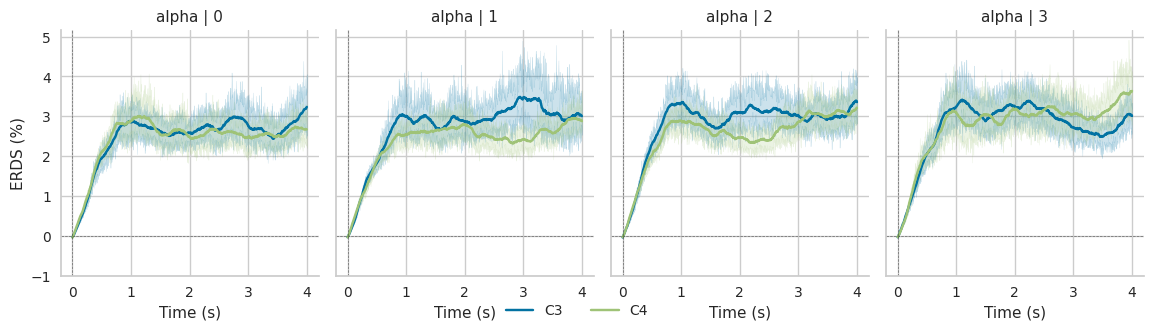

In [68]:
info = mne.create_info(ch_names=ch_names,sfreq = 250 ,ch_types ="eeg")
epochs = mne.EpochsArray(X_syntheic,info,baseline=baseline)
for i in range(y_syntheic.shape[0]):
    epochs.events[i][2] = y_syntheic[i]
epochs.event_id = {'0':0,'1':1,'2':2,'3':3}

epochs.pick_channels(["C3","C4"])
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
                  buffer_size=None, out_type='mask')
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,return_itc=False, average=False, decim=1)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")
df = tfr.to_data_frame(time_format=None, long_format=True)
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])



df = df[df.band.isin(freq_bands_of_interest)]

df['band'] = df['band'].cat.remove_unused_categories()

# Order channels for plotting:
df['channel'] = df['channel'].cat.reorder_categories(('C3', 'C4'),
                                                     ordered=True)

g = sns.FacetGrid(df, row='band', col='condition')
g.map(sns.lineplot, 'time', 'value', 'channel', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(-1, None))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

g.savefig("ERD_Diff/ERD_S{}_Synthetic_data_V2.png".format(subject))
#g.savefig("unicorn/{0}_ERD_S{1}.png".format(runs_name[i],subjects[0]))
g.fig#.clf()

In [69]:
subjects = list(range(1,10))

low_cut_hz = 8.  # low cut frequency for filtering
high_cut_hz = 35.  # high cut frequency for filtering
resample = 128
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000
# Factor to convert from V to uV
factor = 1e6
preprocessors = [
                    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
                    Preprocessor(lambda data: multiply(data, factor)),  # Convert from V to uV
                    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),
                    #Preprocessor('resample', sfreq=resample),
                    Preprocessor(exponential_moving_standardize,  # Exponential movin standardization
                                factor_new=factor_new,
                                 init_block_size=init_block_size)
                    ]
n_epochs = 2000
lr = 0.001

weight_decay = 0.5 * 0.0001
task_list = ['left', 'right', 'foot', 'tongue']
#task_list = ['foot'] ['ATCNet','EEGITNet','ShallowFBCSPNet','EEGnet',"Deep4Net"]
network_list = ['ATCNet','EEGITNet','ShallowFBCSPNet','EEGnet',"Deep4Net"]

#network_list = ['EEGITNet']
#percent_list = [486,648]
percent_list = [18,36,54,72]
gpu_num = 0

dataset = MOABBDataset(dataset_name="BNCI2014001", subject_ids= subject)
preprocess(dataset, preprocessors)
trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
print(sfreq)
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)
splitted = windows_dataset.split('session')
train_set = splitted['session_T']
valid_set = splitted['session_E']

input_window_samples = train_set[0][0].shape[1]
X_train,y_train = extrack_dataset(train_set)


/home/nutapolt/.local/lib/python3.8/site-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 413 samples (1.652 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished


250.0
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
(288, 22, 1125)


Not setting metadata
288 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: percent)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "freq" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


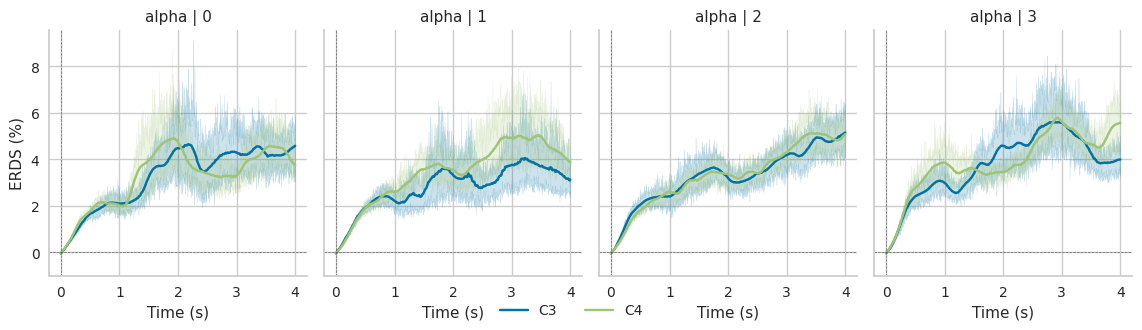

In [70]:
info = mne.create_info(ch_names=ch_names,sfreq = 250 ,ch_types ="eeg")
epochs = mne.EpochsArray(X_train,info,baseline=baseline)
for i in range(y_syntheic.shape[0]):
    epochs.events[i][2] = y_syntheic[i]
epochs.event_id = {'0':0,'1':1,'2':2,'3':3}

epochs.pick_channels(["C3","C4"])
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
                  buffer_size=None, out_type='mask')
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,return_itc=False, average=False, decim=1)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")
df = tfr.to_data_frame(time_format=None, long_format=True)
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])



df = df[df.band.isin(freq_bands_of_interest)]

df['band'] = df['band'].cat.remove_unused_categories()

# Order channels for plotting:
df['channel'] = df['channel'].cat.reorder_categories(('C3', 'C4'),
                                                     ordered=True)

g = sns.FacetGrid(df, row='band', col='condition')
g.map(sns.lineplot, 'time', 'value', 'channel', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(-1, None))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

g.savefig("ERD_Diff/ERD_S{}.png".format(subject))
#g.savefig("unicorn/{0}_ERD_S{1}.png".format(runs_name[i],subjects[0]))
g.fig#.clf()

In [71]:
X_valid,y_valid = extrack_dataset(valid_set)

(288, 22, 1125)


Not setting metadata
288 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: percent)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "freq" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


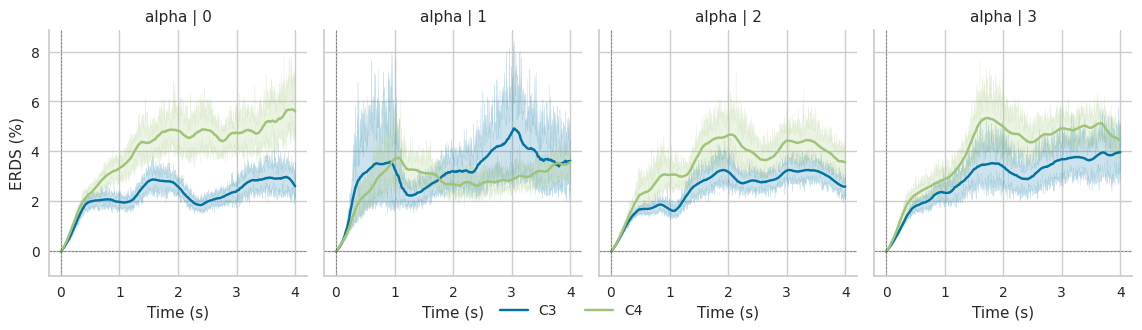

In [72]:
info = mne.create_info(ch_names=ch_names,sfreq = 250 ,ch_types ="eeg")
epochs = mne.EpochsArray(X_valid,info,baseline=baseline)
for i in range(y_syntheic.shape[0]):
    epochs.events[i][2] = y_syntheic[i]
epochs.event_id = {'0':0,'1':1,'2':2,'3':3}

epochs.pick_channels(["C3","C4"])
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
                  buffer_size=None, out_type='mask')
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,return_itc=False, average=False, decim=1)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")
df = tfr.to_data_frame(time_format=None, long_format=True)
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])



df = df[df.band.isin(freq_bands_of_interest)]

df['band'] = df['band'].cat.remove_unused_categories()

# Order channels for plotting:
df['channel'] = df['channel'].cat.reorder_categories(('C3', 'C4'),
                                                     ordered=True)

g = sns.FacetGrid(df, row='band', col='condition')
g.map(sns.lineplot, 'time', 'value', 'channel', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(-1, None))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

g.savefig("ERD_Diff/ERD_S{}_vail.png".format(subject))
#g.savefig("unicorn/{0}_ERD_S{1}.png".format(runs_name[i],subjects[0]))
g.fig#.clf()